---
* 최초 작성일 : 2022.07.08
* 최종 수정일 : 2022.08.16
---

In [ ]:
# Google drive 연결
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


* Python 모듈 import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# **1. 개요 및 데이터**

### 1-1. 개요

<hr style="border: solid 3px blue;">

> **실습목표**
>
> 단조 프레스 작업 후 후속 공정의 소재 품질에 영향을 주는 최종온도 그룹을 예측하기 위한 분석모형을 실습한다.
>
> **실습내용**
>
>1.   단조 생산실적 데이터 로드 및 이해
>2.   탐색적 데이터 분석(EDA), 시각화를 통한 데이터 특성 파악.
>3.   이상 데이터 확인 및 데이터 전처리
>4.   데이터 분리(train, test)
>4.   분류모델 구성 및 학습
>5.   모델 성능 평가
>6.   모델 튜닝
>
> **실습 데이터**
>
>1. 단조(Press Forging)란?
>   철강제품을 고온으로(1000도 이상) 가열해 가압하는 기계적 가공방식을 뜻한다. 
>
>2. 실습데이터는 단조 설비에서 약 1년치 MES 작업실적 데이터로 강종별 ①소재정보와 단조 생산 후 현장에서 측정된 ②최종온도 결과 데이터로 구성되어 있다.
>
>3. ① 강종별 소재정보는 소재ID, 소재구분(BLOOM, INGOT), 제품크기, 제품길이, 투입중량, 투입수량으로 구성되어 있다.<BR>
② 단조 생산 후 최종 온도실적 데이터는 최종온도, 온도그룹으로 되어 있다.
>
> **데이터 구성**
>
>* 데이터는 csv파일로 약 18,310개의 데이터로 구성 되어 있다.
>
>| 컬럼명           | 설명                             |
>|------------------|----------------------------------|
>| MATR_ID          | 소재ID                         |
>| STEEL_NAME       | 강종명              |
>| MATR_TYPE         | 소재구분         |
>| SHAPE         | 형상         |
>| PROD_SIZE     | 제품사이즈    |
>| PROD_LENGTH        | 제품길이                 |
>| INPUT_QTY        | 투입수량                 |
>| INPUT_WGT   | 투입중량            |
>| LAST_TEMPER        | 최종온도           |
>| TEMPER_GROUP    | 온도그룹      |

### 1-2. 데이터 불러오기

In [ ]:
# 파일 Path & 불러오기
file_path = '/content/drive/MyDrive/steel_ai_data/steel_ai_05.csv'
press_df = pd.read_csv(file_path, header=0)

press_df.head()

,matr_id,steel_name,matr_type,shape,prod_size,prod_length,input_wgt,input_qty,last_temper,temper_group
0,101,steel001,I,R,170.0,14917.0,4000,1,786.0,B
1,102,steel001,I,R,170.0,14917.0,4000,1,752.0,B
2,103,steel001,I,R,170.0,14917.0,4000,1,760.0,B
3,104,steel001,I,R,170.0,14917.0,4000,1,836.0,C
4,105,steel001,I,R,170.0,14917.0,4000,1,787.0,B


### 1-3. 데이터 확인

* info() 함수를 통해 dataframe을 구성하는 행과 열의 크기, 컬럼명, 컬럼을 구성하는 값의 자료형 등을 출력 한다
* 데이터 확인 요약
  * 전체 건수 : 18,310건
  * 컬럼 수 : 10개
  * 데이터 타입 : float64(3개), int64(3개), object(4개)
* null 확인
  * 전체건수에 미달되는 컬럼들에 대해서는 null값이 포함되어 있다.
  * 전처리에서 의미없는 데이터일 경우 삭제처리 하거나 아니면 다른 값으로 채워 준다.
* 데이터 타입 확인
  * STEEL_NAME, MATR_TYPE, SHAPE, TEMPER_GROUP 컬럼의 경우 object형 확인
  * 전처리에서 카테고리형 데이터(Categorical Data)를 수치형 데이터(Numerical Data)로 변환해주는 작업이 필요하다.

| 데이터 타입     | 설명                 |
|:---------------:|----------------------|
| object          | 문자열 or 복합형     |
| int64           | 정수형               |
| float64         | 실수형               |
| bool            | boolean(참/거짓)     |
| category        | 카테고리형           |
| <left>데이터 타입 관련 참고 : [링크](https://wikidocs.net/78180)  |

In [ ]:
# 데이터에 대한 전반적인 정보 확인
press_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18310 entries, 0 to 18309
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   matr_id       18310 non-null  int64  
 1   steel_name    18310 non-null  object 
 2   matr_type     18310 non-null  object 
 3   shape         18300 non-null  object 
 4   prod_size     18300 non-null  float64
 5   prod_length   18300 non-null  float64
 6   input_wgt     18310 non-null  int64  
 7   input_qty     18310 non-null  int64  
 8   last_temper   18292 non-null  float64
 9   temper_group  18292 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 1.4+ MB


* null 확인
  * SHAPE, PROD_SIZE, PROD_LENGTH, LAST_TEMPER, TEMPER_GROUP 컬럼 null 확인

In [ ]:
# 컬럼들의 대한 null count 확인
press_df.isnull().sum()

matr_id          0
steel_name       0
matr_type        0
shape           10
prod_size       10
prod_length     10
input_wgt        0
input_qty        0
last_temper     18
temper_group    18
dtype: int64

* 수치형 데이터 요약 확인
* describe() 다양한 통계량을 요약해주는 메서드이다.(DataFrame의 정보요약)
  * count : 컬럼별 총 데이터수
  * mean, std : 컬럼별 데이터의 평균, 표준편차
  * min, max : 컬럼별 데이터 최소값, 최대값
  * 25%, 50%, 75% : 백분위수의 각 지점으로, 분포를 반영해 평균을 보완하는 목적으로 사용

In [ ]:
# 수치형 데이터 요약
press_df.describe()

,matr_id,prod_size,prod_length,input_wgt,input_qty,last_temper
count,18310.000000,18300.000000,18300.000000,18310.000000,18310.0,18292.000000
mean,129.079738,150202.968507,6437.056885,6545.226543,1.0,825.850590
std,47.125525,179698.731103,1520.184512,4191.830757,0.0,57.957727
min,101.000000,120.000000,731.000000,978.000000,1.0,256.000000
25%,105.000000,310.000000,5660.000000,4000.000000,1.0,783.000000
50%,113.000000,482.000000,6095.000000,5800.000000,1.0,832.000000
75%,134.000000,315265.000000,6851.000000,7700.000000,1.0,870.000000
max,810.000000,970330.000000,31368.000000,24900.000000,1.0,1254.000000


# **2. 데이터 탐색**

* 데이터 건수 요약
  * 전체 건수 : 18,310건
  * 컬럼 수 : 10개

In [ ]:
# 전체 데이터 건수 및 컬럼 확인
press_df.shape

(18310, 10)

### 2-1. 개별 분포 확인



> #### 2-1-1. 범주형 분포 확인

* 강종(STEEL_NAME) 72개의 강종으로 이루어져 있다.
* 소재구분(MATR_TYPE) I(Ingot), B(Bloom) 2가지 소재로 구분되어 있다.
* 형상(SHAPE)은 투입되는 철강 소재의 형태를 의미한다. R(Round, 원형), S(Square, 정사각형) 2가지 형상으로 구분되어 있다.
* 온도그룹(TEMPER_GROUP)은 5개(A,B,C,D,E) 그룹으로 구성되어 있고, C, D그룹이 분포가 많으며, E그룹이 제일 적게 확인된다.



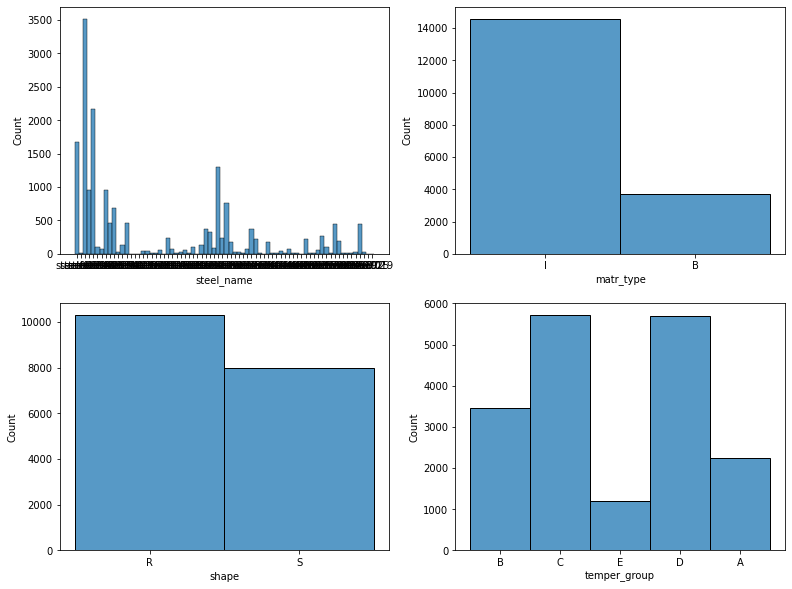

In [ ]:
# 모든 범주형 변수에 대해 히스토그램 시각화 확인
press_tmp = press_df[['steel_name','matr_type','shape','temper_group']]

plt.figure(figsize=(13, 10))
df_tmp = press_tmp.select_dtypes([object])
for i, col in enumerate(df_tmp.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(x = col, data = df_tmp)

> #### 2-1-2. 수치형 분포 확인

* 수치형 분포 확인은 원형과 정사각형을 각각 구분해서 확인을 하였다.
* **원형(Round) 수치형 개별 분포 확인**
  * 소재ID(MATR_ID)는 강종별로 ID가 발급되며, 해당 데이터셋에서는 아무 의미가 없는 항목이므로 차후 데이터 전처리 시 삭제해도 무방하다.
  * 제품사이즈(PROD_SIZE)는 R(Round,원형)은 100~850파이 사이에 데이터가 분포되어 있다.
  * 제품길이(PROD_LENGTH)는 5000~8000 사이제 많은 데이터가 분포되어 있다.
  * 투입중량(INPUT_WGT)은 3000~8000 사이에 좀 더 많은 데이터가 분포되어 있다.
  * 투입수량(INPUT_QTY)은 데이터값이 극단적으로 하나만 있는 것처럼 보여진다.
  * 최종온도(LAST_TEMPER)는 700도~950도 사이에 데이터가 집중적으로 분포되어 있다.
* histplot(histogram) 함수를 사용하여 데이터 분포 시각화

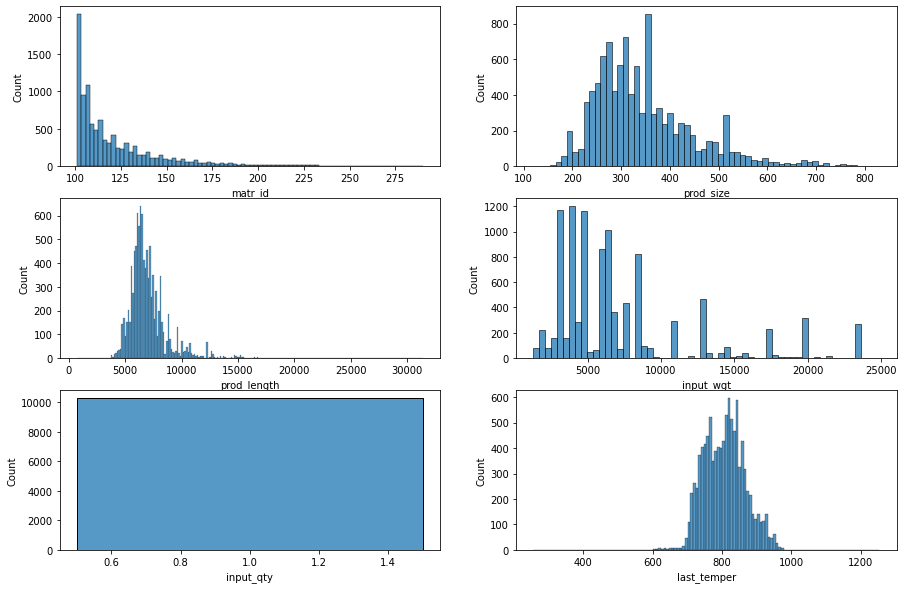

In [ ]:
# 원형(Round) 수치형 변수에 대해 히스토그램 확인
r_press_tmp = press_df[press_df['shape'] == 'R'][['matr_id','prod_size','prod_length','input_wgt','input_qty','last_temper']]

plt.figure(figsize=(15, 10))
df_tmp = r_press_tmp.select_dtypes([int, float])
for i, col in enumerate(df_tmp.columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(x = col, data = df_tmp)

* **사각형(Square) 수치형 개별 분포 확인**
  * 제품사이즈(PROD_SIZE)는 S(Square,사각형)은 (가로세로) 210001~400999 사이에 데이터가 분포되어 있다.
  * 제품길이(PROD_LENGTH)는 5000~7000 사이제 많은 데이터가 분포되어 있다.
  * 투입중량(INPUT_WGT)은 3000~8000 사이에 좀 더 많은 데이터가 분포되어 있는데, 특정 중량에 집중적으로 생산이 이루어진것 같다.
  * 투입수량(INPUT_QTY)은 데이터값이 극단적으로 하나만 있는 것처럼 보여진다.
  * 최종온도(LAST_TEMPER)는 700도~950도 사이에 데이터가 집중적으로 분포되어 있다.
* histplot(histogram) 함수를 사용하여 데이터 분포 시각화

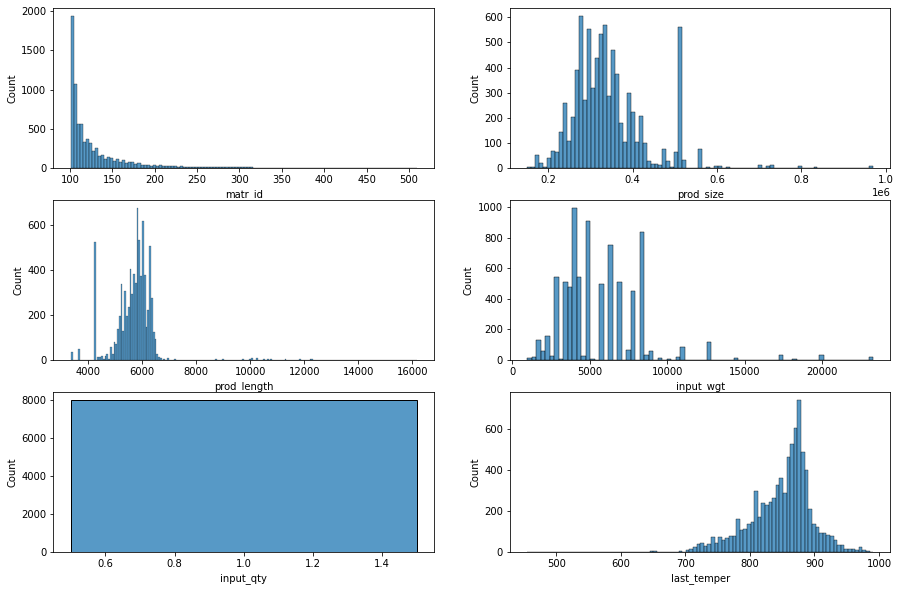

In [ ]:
# 사각형(Square) 수치형 변수에 대해 히스토그램 확인
r_press_tmp = press_df[press_df['shape'] == 'S'][['matr_id','prod_size','prod_length','input_wgt','input_qty','last_temper']]

plt.figure(figsize=(15, 10))
df_tmp = r_press_tmp.select_dtypes([int, float])
for i, col in enumerate(df_tmp.columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(x = col, data = df_tmp)

### 2-2. 온도그룹별 분포 확인

* 온도룹별 데이터 분포 확인
* countplot 함수를 사용하여 최종온도 그룹별 데이터 분포 시각화
  * 최종온도 그룹 중에서 최대건수('C'그룹), 최소건수('B'그룹)으로 데이터가 구성되어 있다.

▣ 최종온도 그룹별 데이터 건수
temper_group
A    2234
B    3449
C    5716
D    5694
E    1199
Name: temper_group, dtype: int64



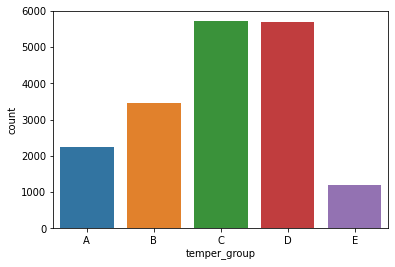

In [ ]:
# 최종온도 그룹별 데이터 건수
print('▣ 최종온도 그룹별 데이터 건수\n{0}\n'.format(press_df.groupby('temper_group')['temper_group'].count()))

# 최종온도 그룹별 데이터 건수 분포 시각화
sns.countplot(x = 'temper_group', data = press_df.sort_values(by='temper_group', ascending=True))

* countplot 함수를 사용하여 온도그룹별 데이터 분포 시각화
  * 최종온도 그룹 기준
    * **A-Group : 700 ~ 750**
    * **B-Group : 751 ~ 800**
    * **C-Group : 801 ~ 850**
    * **D-Group : 851 ~ 900**
    * **E-Group : 901 ~ 950**



* 그룹별 온도 분포 확인
  * 그룹별 온도 분포에서 벗어 났다고 해도 +/- 30~40도 오차 발생할 수 있으며, 또한 다른 여러가지 요인으로 그룹범위 온도를 완전 벗어 날수도 있다.
  * 그렇지만 전체적인 700~950도 온도 범위에 데이터가 분포하고 있으며, 이 범위에서 좀더 벗어 났다고 해도 다른 기타 요인 변수로 발생해서 온도가 낮거나, 높을수 있기 때문에 이것을 이상치 값으로 보기는 어렵다.

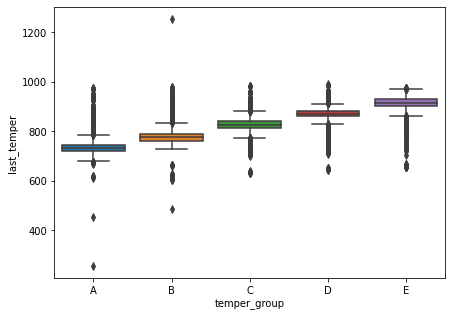

In [ ]:
fig, axes = plt.subplots(figsize=(7, 5))

# 온도그룹별 최종온도 데이터 분포 확인
sns.boxplot(x='temper_group', y='last_temper', data=press_df.sort_values(by='temper_group', ascending=True))
plt.show()

* **도메인 지식(현업)에 따른 단조 최종온도를 결정하는 중요 요소**
  * **제품사이즈(크기), 제품길이**
    * 제품크기와 제품길이는 최종온도에 반비례한다.
      * 제품크기가 작을수록 단조 치는 시간이 짧아서 최종온도는 높다. 반대로 제품크기가 클수록 단조 치는 시간이 길어서 최종온도는 낮아진다.
      * 제품길이도 길이가 짧을수록 단조 치는 시간이 짧아서 최종온도는 높다. 반대로 제품길이가 길수록 단조 치는 시간이 길어서 최종온도는 낮아진다.

      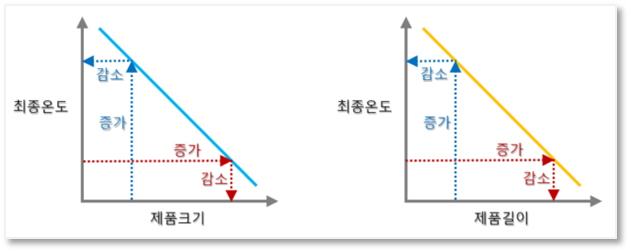

    * 제품크기와 제품길이는 반비례 되어 최종온도가 결정된다.
      * 제품크기가 작은데 제품길이가 길면 최종온도는 낮아진다. 즉, 크기가 작지만 길이가 길어서 단조 치는 시간이 오래걸려 최종온도가 낮아지게 된다.

      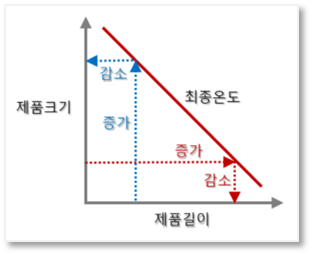

  * **강종특성**
    * 강종의 성분 특성에 따라 철강소재의 온도하강 속도가 다를 수 있다.
    * 똑같은 단조 작업 시간에 어떤 강종은 온도가 빨리 내려가고, 어떤 강종은 천천히 내려가는 강종이 있다.
  * 기타 - 작업자 숙련도, 현장 작업준비 및 설비세팅, 부품교체, 설비이상 등등

* **원형(Round)** 제품크기 및 제품길이에 따른 최종온도 데이터 분포 확인
  * **제품크기, 제품길이가 커질수록 온도는 낮아지는 경향을 보인다.**
  * 추가로, 사이즈는 작지만 길이가 길어서 온도가 낮게 분포된 경향도 파악할 수 있다.

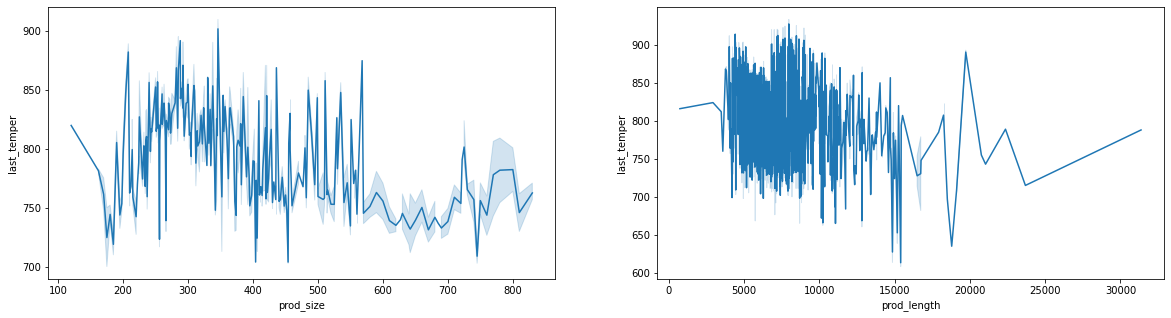

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# 원형(Round) 제품사이즈와 제품길이의 최종온도 데이터 분포 확인(전체 데이터)
sns.lineplot(x='prod_size', y='last_temper', data=press_df[press_df['shape']=='R'], ax=axes[0])
sns.lineplot(x='prod_length', y='last_temper', data=press_df[press_df['shape']=='R'], ax=axes[1])
# 원형(Round) 제품사이즈와 제품길이의 최종온도 데이터 분포 확인(평균) - 전체 데이터 조회 시 기간이 걸림(평균으로 대체)
# press_df[press_df['shape']=='R'].groupby(['prod_size'])['last_temper'].mean().plot(ax=ax[0])
# press_df[press_df['shape']=='R'].groupby(['prod_length'])['last_temper'].mean().plot(ax=ax[1])
plt.show()

* **제품크기와 제품길이 대비 온도 분포를 좀더 직관적으로 확인해 본다.**
  * **분석용 파생변수를 생성**한다.
  * 제품크기와 제품길이 종류가 다양하므로 범위를 좀더 일반화 시켜서 시각화 처리를 한다.
  * 예) 제품크기(220, 230, 235, 238, 240, 245) → 제품크기2(200)

* **원형(Round)** 제품크기 및 제품길이 범위를 일반화 시키기 위한 분석용 컬럼 추가
  * 원형제품크기2(r_prod_size2), 원형제품길이2(r_prod_length2)

In [ ]:
# 원형 데이터만 추출하여 분석을 위한 임시 DataFrame 구성
r_press_tmp = press_df[press_df['shape'] == 'R']

# 메시지 알림 설정
pd.set_option('mode.chained_assignment',  None)

# 제품크기 범위를 50으로 일반화 시킨후 제품크기2(prod_size2) 항목 추가
for i in range(100, 850, 50):
  for k, row in r_press_tmp.iterrows():
    if (r_press_tmp.at[k, 'prod_size'] >= (i - 50) and r_press_tmp.at[k, 'prod_size'] <= i):
      r_press_tmp.at[k, 'r_prod_size2'] = i
    else:
      0

# 제품길이 범위를 100으로 일반화 시킨후 제품길이2(prod_length2) 항목 추가
for i in range(1000, 40000, 1000):
  for k, row in r_press_tmp.iterrows():
    if (r_press_tmp.at[k, 'prod_length'] >= (i - 1000) and r_press_tmp.at[k, 'prod_length'] <= i):
      r_press_tmp.at[k, 'r_prod_length2'] = i
    else:
      0

r_press_tmp.head(5)

,matr_id,steel_name,matr_type,shape,prod_size,prod_length,input_wgt,input_qty,last_temper,temper_group,r_prod_size2,r_prod_length2
0,101,steel001,I,R,170.0,14917.0,4000,1,786.0,B,200.0,15000.0
1,102,steel001,I,R,170.0,14917.0,4000,1,752.0,B,200.0,15000.0
2,103,steel001,I,R,170.0,14917.0,4000,1,760.0,B,200.0,15000.0
3,104,steel001,I,R,170.0,14917.0,4000,1,836.0,C,200.0,15000.0
4,105,steel001,I,R,170.0,14917.0,4000,1,787.0,B,200.0,15000.0


* **원형(Round)** 제품크기 및 제품길이 범위를 일반화 시킨 후 최종온도 데이터 분포 확인

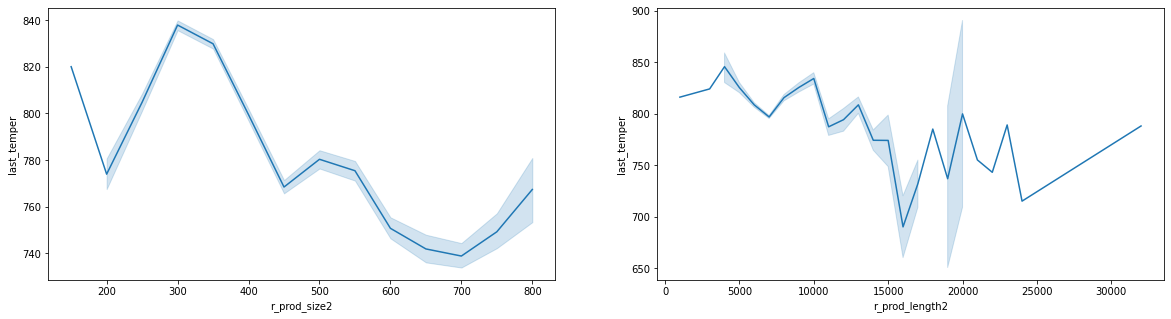

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

# 원형(Round) 제품사이즈와 제품길이의 최종온도 데이터 분포 확인
sns.lineplot(x='r_prod_size2', y='last_temper', data=r_press_tmp[r_press_tmp['shape']=='R'], ax=ax[0])
sns.lineplot(x='r_prod_length2', y='last_temper', data=r_press_tmp[r_press_tmp['shape']=='R'], ax=ax[1])

* **정사각형(Square)** 제품크기 및 제품길이에 따른 최종온도 데이터 분포 확인
  * 원형과 마찬가지로 **제품크기, 제품길이가 커질수록 온도는 낮아지는 경향을 보인다.**

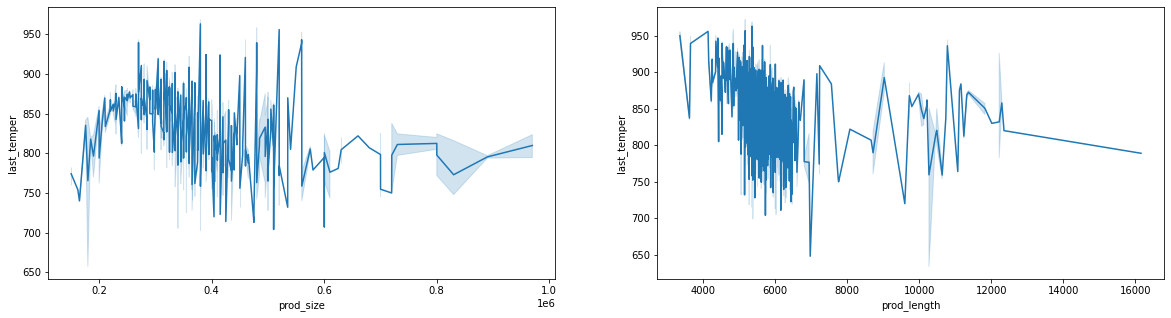

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# 사각형(Square) 제품사이즈와 제품길이의 최종온도 데이터 분포 확인(전체 데이터)
sns.lineplot(x='prod_size', y='last_temper', data=press_df[press_df['shape']=='S'], ax=axes[0])
sns.lineplot(x='prod_length', y='last_temper', data=press_df[press_df['shape']=='S'], ax=axes[1])
# 사각형(Square) 제품사이즈와 제품길이의 최종온도 데이터 분포 확인(평균)
# press_df[press_df['shape']=='S'].groupby(['prod_size'])['last_temper'].mean().plot(ax=ax[0])
# press_df[press_df['shape']=='S'].groupby(['prod_length'])['last_temper'].mean().plot(ax=ax[1])
plt.show()

* **정사각형(Square)** 제품크기 및 제품길이 범위를 일반화 시키기 위한 분석용 컬럼 추가
  * 사각형제품크기2(s_prod_size2), 사각형제품길이2(s_prod_length2)

In [ ]:
# 정사각형 데이터만 추출하여 분석을 위한 임시 DataFrame 구성
s_press_tmp = press_df[press_df['shape'] == 'S']

# 메시지 알림 설정
pd.set_option('mode.chained_assignment',  None)

# 제품크기 범위를 50으로 일반화 시킨후 제품크기2(prod_size2) 항목 추가
for i in range(100000, 1000000, 100000):
  for k, row in s_press_tmp.iterrows():
    if (s_press_tmp.at[k, 'prod_size'] >= (i - 100000) and s_press_tmp.at[k, 'prod_size'] <= i):
      s_press_tmp.at[k, 's_prod_size2'] = i
    else:
      0

# 제품길이 범위를 1000으로 일반화 시킨후 제품길이2(prod_length2) 항목 추가
for i in range(1000, 40000, 1000):
  for k, row in s_press_tmp.iterrows():
    if (s_press_tmp.at[k, 'prod_length'] >= (i - 1000) and s_press_tmp.at[k, 'prod_length'] <= i):
      s_press_tmp.at[k, 's_prod_length2'] = i
    else:
      0

s_press_tmp.head(5)

,matr_id,steel_name,matr_type,shape,prod_size,prod_length,input_wgt,input_qty,last_temper,temper_group,s_prod_size2,s_prod_length2
153,107,steel030,I,S,180180.0,10273.0,3300,1,455.0,A,200000.0,11000.0
185,109,steel030,I,S,180180.0,10273.0,3300,1,486.0,B,200000.0,11000.0
226,102,steel030,I,S,340240.0,6028.0,4800,1,623.0,B,400000.0,7000.0
775,106,steel032,I,S,365305.0,6975.0,7800,1,648.0,D,400000.0,7000.0
777,111,steel030,I,S,385330.0,5382.0,6900,1,649.0,D,400000.0,6000.0


* **정사각형(Square)** 제품크기 및 제품길이 범위를 일반화 시킨 후 최종온도 데이터 분포 확인

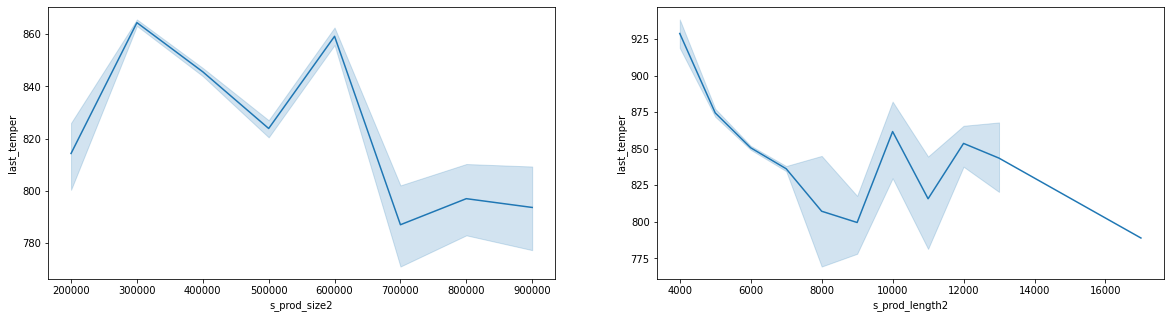

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

# 정사각형(Square) 제품사이즈와 제품길이의 최종온도 데이터 분포 확인
sns.lineplot(x='s_prod_size2', y='last_temper', data=s_press_tmp[s_press_tmp['shape']=='S'], ax=ax[0])
sns.lineplot(x='s_prod_length2', y='last_temper', data=s_press_tmp[s_press_tmp['shape']=='S'], ax=ax[1])

### 2-3. 상관관계 확인

* 상관 관계분석 이란? 두 변수간에 어떤 선형적 관계를 가지는지 분석하는 기법으로 상관계수를 이용하여 측정한다.
* 상관계수 - 두 변수 사이의 직선 관계를 나타내는 지표이다.
  * -1 ~ 1 사이 값을 가지며 절대값이 1에 가까울수록 강한 선형 관계를 의미한다.
* **제품길이, 제품사이즈 간 상관관계가 높음**을 알 수 있다.

,matr_id,prod_size,prod_length,input_wgt,input_qty,last_temper
matr_id,1.000000,0.203559,-0.101529,-0.033978,NaN,0.201600
prod_size,0.203559,1.000000,-0.431867,-0.075067,NaN,0.311325
prod_length,-0.101529,-0.431867,1.000000,0.244928,NaN,-0.204023
input_wgt,-0.033978,-0.075067,0.244928,1.000000,NaN,-0.367683
input_qty,NaN,NaN,NaN,NaN,NaN,NaN
last_temper,0.201600,0.311325,-0.204023,-0.367683,NaN,1.000000


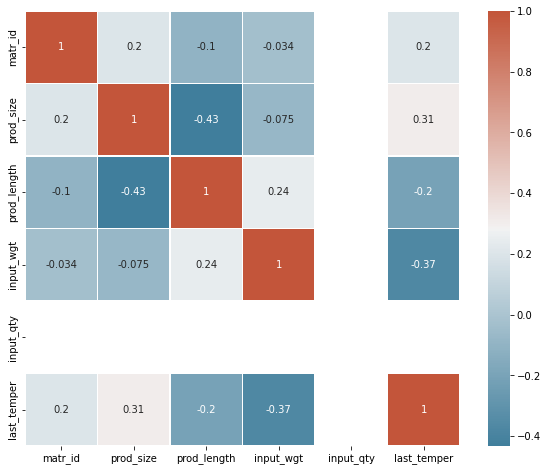

In [ ]:
# 상관관계 통계표 시각화
plt.figure(figsize=(10,8))
corr = press_df.corr()

#corr:상관계수를 구하는 pandas 내장 함수
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, square=True, linewidths=.5)
corr

# **3. 데이터 전처리**

### 3-1. 결측값 처리

* 결측값(Missing Values)이란? 값이 없는 경우를 의미한다.
  * Python pandas에서는 결측값을 'NaN' 으로 표기하며, 'None'도 결측값으로 인식한다.
  * 결측값이 있는 상태로 모델을 만들게 될 경우 변수간의 관계가 왜곡될수 있기 때문에 모델의 정확성이 떨어지게 된다.

* 전체 데이터 결측값(Missing Values) 확인
  * 제품크기(prod_size) & 제품길이(prod_length) 결측값 : 10개
  * 최종온도(last_temper) & 온도그룹(temper_group) 결측값 : 18개



In [ ]:
# 결측값 확인
press_df.isnull().sum()

matr_id          0
steel_name       0
matr_type        0
shape           10
prod_size       10
prod_length     10
input_wgt        0
input_qty        0
last_temper     18
temper_group    18
dtype: int64

* 결측값 제거
  * 결측값이 포함된 사용할 수 없는 데이터 삭제 처리
  * 제품크기(prod_size), 제품길이(prod_length), 최종온도(last_temper), 온도그룹(temper_group) 컬럼에 결측값이 있는 row 삭제한다.
  * 삭제 row 건수 : 10건

In [ ]:
# 제품크기 & 제품길이 항목의 결측값 row 삭제 처리
print('삭제 전 Count : {0}\n'.format (press_df.shape))
press_df = press_df.dropna(subset=['prod_size','prod_length'], axis=0)
press_df

삭제 전 Count : (18310, 10)



,matr_id,steel_name,matr_type,shape,prod_size,prod_length,input_wgt,input_qty,last_temper,temper_group
0,101,steel001,I,R,170.0,14917.0,4000,1,786.0,B
1,102,steel001,I,R,170.0,14917.0,4000,1,752.0,B
2,103,steel001,I,R,170.0,14917.0,4000,1,760.0,B
3,104,steel001,I,R,170.0,14917.0,4000,1,836.0,C
4,105,steel001,I,R,170.0,14917.0,4000,1,787.0,B
...,...,...,...,...,...,...,...,...,...,...
18305,105,steel029,B,S,360270.0,4861.0,4256,1,874.0,E
18306,106,steel029,B,S,360270.0,4861.0,4256,1,879.0,E
18307,102,steel029,B,S,360280.0,4739.0,4300,1,890.0,E
18308,104,steel029,B,S,360280.0,4739.0,4301,1,890.0,E


* 결측값 대체 처리 대상 데이터 확인
  * 최종온도(last_temper) & 온도그룹(temper_group) 결측값 확인

In [ ]:
# 최종온도 & 온도그룹 결측값 데이터 확인
press_df[(press_df['last_temper'].isnull() & press_df['temper_group'].isnull())]

,matr_id,steel_name,matr_type,shape,prod_size,prod_length,input_wgt,input_qty,last_temper,temper_group
17548,114,steel001,I,R,360.0,7582.0,8500,1,NaN,NaN
17549,115,steel001,I,R,360.0,7582.0,8500,1,NaN,NaN
17550,116,steel001,I,R,360.0,7582.0,8500,1,NaN,NaN
17551,117,steel001,I,R,360.0,7582.0,8500,1,NaN,NaN
17552,118,steel001,I,R,360.0,7582.0,8500,1,NaN,NaN
17553,119,steel001,I,R,360.0,7582.0,8500,1,NaN,NaN
17554,120,steel001,I,R,360.0,7582.0,8500,1,NaN,NaN
17555,121,steel001,I,R,360.0,7582.0,8500,1,NaN,NaN


* 최종온도의 결측값 대체를 위한 평균값을 구한다.
  * 최종온도 컬럼의 전체 평균값이 아닌 특정 범위의 평균값을 구한다.
  * 특정 범위의 평균값 조건은 **강종 & 제품크기 & 제품길이** 항목으로 한다.

In [ ]:
condition = ((press_df.steel_name == 'steel001') & (press_df.prod_size == 360.0) & (press_df.prod_length == 7582.0))
avg = round(press_df.loc[condition, 'last_temper'].mean())
print('평균 최종온도값 : {0}'.format(round(avg)))

평균 최종온도값 : 907


* 결측값 대체 처리
  * 온도그룹은 평균 최종온도값의 기준 온도그룹으로 대체 처리 한다.
  * **E-Group : 901 ~ 950**

In [ ]:
# 특정 조건 평균값 및 온도그룹값으로 결측값 대체
temper_grp = 'E'

press_df["last_temper"] = press_df["last_temper"].fillna(avg)
press_df["temper_group"] = press_df["temper_group"].fillna(temper_grp)
press_df[condition].isnull().sum()

matr_id         0
steel_name      0
matr_type       0
shape           0
prod_size       0
prod_length     0
input_wgt       0
input_qty       0
last_temper     0
temper_group    0
dtype: int64

### 3-2. 이상값 처리

* 최종온도의 데이터 정보를 요약하여 온도그룹의 범위를 벗어 났으면 이상치로 판단 한다.
* 온도 최소값(MIN)이 256도이고, 최대값(MAX)이 1254도 이다.
  * 분포된 데이터들을 완전히 벗어 났으므로 이상치 값으로 판단이 되어 삭제해도 무방하다.

In [ ]:
# 최종온도 데이터 요약
press_df[['last_temper']].describe()

,last_temper
count,18300.000000
mean,825.886066
std,57.969883
min,256.000000
25%,783.000000
50%,832.000000
75%,870.000000
max,1254.000000


* 이상치 데이터 확인
  * 최종온도의 MIN값, MAX값과 온도그룹 기준 ±20% 정도 벗어난 값을 이상치로 판단한다.
  * 그렇지만 정확한 기준으로 이상,이하값을 이상치를 판단하기 보다는 현장의 작업자의 판단으로 처리하는 경우가 많으므로, 600도 이하, 1000도 이상을 이상치라고 판단을 한다.

In [ ]:
# 이상치 조건에 맞는 데이터 확인
out_condition = ((press_df.last_temper <= 600) | (press_df.last_temper >= 1000))
press_df[out_condition]

,matr_id,steel_name,matr_type,shape,prod_size,prod_length,input_wgt,input_qty,last_temper,temper_group
150,101,steel062,B,R,250.0,5737.0,2552,1,256.0,A
153,107,steel030,I,S,180180.0,10273.0,3300,1,455.0,A
185,109,steel030,I,S,180180.0,10273.0,3300,1,486.0,B
16057,117,steel058,I,R,400.0,6131.0,7700,1,1254.0,B


* **이상치 제거**
  * 이상치 조건의 범위를 벗어난 데이터를 삭제한다.

In [ ]:
# 이상치 조건에 맞는 데이터 삭제
print('삭제 전 Count : {0}\n'.format (press_df.shape))
idx = press_df[out_condition].index
press_df.drop(idx, inplace=True)
press_df

삭제 전 Count : (18300, 10)



,matr_id,steel_name,matr_type,shape,prod_size,prod_length,input_wgt,input_qty,last_temper,temper_group
0,101,steel001,I,R,170.0,14917.0,4000,1,786.0,B
1,102,steel001,I,R,170.0,14917.0,4000,1,752.0,B
2,103,steel001,I,R,170.0,14917.0,4000,1,760.0,B
3,104,steel001,I,R,170.0,14917.0,4000,1,836.0,C
4,105,steel001,I,R,170.0,14917.0,4000,1,787.0,B
...,...,...,...,...,...,...,...,...,...,...
18305,105,steel029,B,S,360270.0,4861.0,4256,1,874.0,E
18306,106,steel029,B,S,360270.0,4861.0,4256,1,879.0,E
18307,102,steel029,B,S,360280.0,4739.0,4300,1,890.0,E
18308,104,steel029,B,S,360280.0,4739.0,4301,1,890.0,E


### 3-3. 컬럼삭제

* 의미없는 컬럼이나 1개의 값을 가진 컬럼을 삭제 한다.
  * 소재ID(MATR_ID), 강종명(STEEL_NAME), 소재구분(MATR_TYPE), 수량(QTY) 컬럼 삭제

In [ ]:
# 컬럼 삭제
press_df = press_df.drop(['matr_id','steel_name','matr_type','input_qty'], axis=1, inplace=False)
press_df.head(5)

,shape,prod_size,prod_length,input_wgt,last_temper,temper_group
0,R,170.0,14917.0,4000,786.0,B
1,R,170.0,14917.0,4000,752.0,B
2,R,170.0,14917.0,4000,760.0,B
3,R,170.0,14917.0,4000,836.0,C
4,R,170.0,14917.0,4000,787.0,B


### 3-4. Feature engineering

* 카테고리형 데이터(Categorical Data)를 수치형 데이터(Numerical Data)로 변환한다.
  * sklearn.preprocessing의 LabelEncoder 모듈을 사용하여 간단하게 전처리 작업을 처리 한다.
  * 수치형 데이터로 변환 시켜야 할 항목은 강종명(STEEL_NAME), 형상(SHAPE), 온도그룹(TEMPER_GROUP) 3개 이다.



In [ ]:
# 범주형 데이터를 수치형 데이터로 변화 처리
from sklearn import preprocessing

# 문자열 Feature → 숫자형 Feature 변환 처리 하기위한 encode_features() 함수 생성
# 사이킷런의 전치리 모듈의 대부분 인코딩 API는 사이킷런의 기본 프레임워크 API인 fit(), transform()으로 데이터를 변환한다.
def encode_features(dataDF):
    # features = ['steel_name', 'shape', 'temper_group']
    features = ['shape', 'temper_group']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

# encode_features() 함수 호출
press_df = encode_features(press_df)
press_df.head()

,shape,prod_size,prod_length,input_wgt,last_temper,temper_group
0,0,170.0,14917.0,4000,786.0,1
1,0,170.0,14917.0,4000,752.0,1
2,0,170.0,14917.0,4000,760.0,1
3,0,170.0,14917.0,4000,836.0,2
4,0,170.0,14917.0,4000,787.0,1


# **4. 모델 준비**

### 4-1. 데이터 준비

* 데이터 분리 전 최종 컬럼 확인

In [ ]:
# 데이터 컬럼 확인
press_df.head(3)

,shape,prod_size,prod_length,input_wgt,last_temper,temper_group
0,0,170.0,14917.0,4000,786.0,1
1,0,170.0,14917.0,4000,752.0,1
2,0,170.0,14917.0,4000,760.0,1


* 최종온도(LAST_TEMPER) 컬럼을 Target(Label) 데이터로 한다.
* Features 데이터에는 최종온도(LAST_TEMPER) 컬럼을 삭제한다.

In [ ]:
# 컬럼 삭제 및 최종온도 컬럼을 Label 데이터로 생성
y_target = press_df['temper_group']
X_features = press_df.drop(['temper_group'], axis=1, inplace=False)

### 4-2. 데이터 분리

* scikit-learn library의 train_test_split 사용하여 훈련 데이터와 테스트 데이터를 분리한다.
* 훈련데이터와 학습데이터 구성
  * 데이터는 7:3 비율로 설정 한다.
  * 실행시마다 동일한 결과를 얻기위해 random_state 설정한다.

  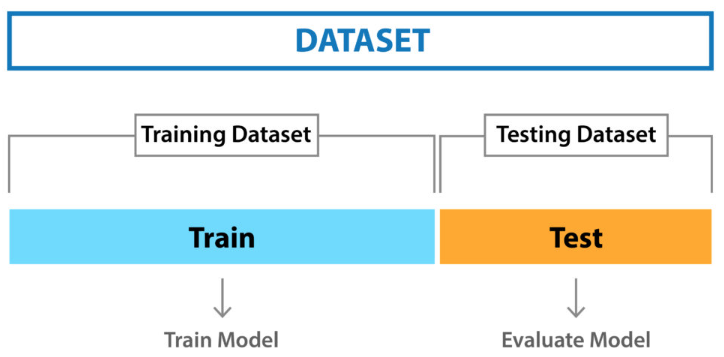

In [ ]:
# train_test_split 모듈을 사용하여 데이터분리 처리
from sklearn.model_selection import train_test_split

# 훈련데이터와 학습데이터 분리(7:3비율)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=119)

# **5. 모델링**

* scikit-learn 라이브러리
  * 기계학습(Machine Learning) 에 많이 사용되는 python 라이브러리로 회귀모델, 분류모델, 클러스터링 알고리즘 등 기계학습에서 자주 사용하는 알고리즘이 구현되어 있다.
  * 전처리 및 성능평가 등 알고리즘 이외에 기계학습에서 사용되는 다양한 기법도 포함되어 있어서 자유롭게 사용할 수 있다.
* **분류(Classification)**
  * 분류는 학습 데이터로 주어진 데이터의 피처와 레이블값(결정 값, 클래스 값)을 머신러닝 알고리즘으로 학습해 모델을 생성하고, 이렇게 생성된 모델에 새로운 데이터 값이 주어졌을 때 미지의 레이블 값을 예측 하는 것이다.


### 5-1. 랜덤포레스트(Random Forest)

* 랜덤 포레스트는 결정 트리를 기반으로 하는 알고리즘 이며, 여러 개의 결정 트리 분류기가 배깅을 기반으로 각자의 데이터를 샘플링 하여 학습을 수행한 후에 최종적으로 보팅을 통해 예측 결정을 하게 된다.
* “무작위 숲”이라는 이름처럼 랜덤 포레스트는 훈련을 통해 구성해놓은 다수의 나무들로부터 분류 결과를 취합해서 결론을 얻는, 일종의 인기 투표와 같은 거다.
* 사이킷런에서는 RandomForestClassifier 클래스를 통해서 랜덤 포레스트 기반의 분류를 지원한다.

* Random Forest 모델학습 및 예측

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 모델객체 선언
rf_model = RandomForestClassifier(random_state=11)
# 모델학습
rf_model.fit(X_train, y_train)
# 모델예측
rf_pred = rf_model.predict(X_test)

* 정확도(Accuracy) 평가 확인

In [ ]:
from sklearn.metrics import accuracy_score

# 정확도 평가 확인
accuracy = accuracy_score(y_test, rf_pred)
print('정확도: {0:.4f}'.format(accuracy))

정확도: 0.9244


### 5-2. 의사결정나무(Decision Tree)

* **의사결정나무(decision tree)**는 여러 가지 규칙을 순차적으로 적용하면서 독립 변수 공간을 분할하는 분류 모형이다. 분류(classification)와 회귀 분석(regression)에 모두 사용될 수 있기 때문에 **CART(Classification And Regression Tree)**라고도 한다.

* Decision Tree 모델학습 및 예측

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 모델객체 선언
dt_model = DecisionTreeClassifier(random_state=11)
# 모델 학습
dt_model.fit(X_train, y_train)
# 모델예측
dt_pred = dt_model.predict(X_test)

* 정확도(Accuracy) 평가 확인

In [ ]:
from sklearn.metrics import accuracy_score

# 정확도 평가 확인
accuracy = accuracy_score(y_test, dt_pred)
print('정확도: {0:.4f}'.format(accuracy))

정확도: 0.9133


* 생성된 의사결정나무 확인 및 시각화
  * max_depth=5으로 제한한 Decision Tree 시각화
  * 전체 depth 확인 시 max_depth 옵션 삭제 처리 한다.

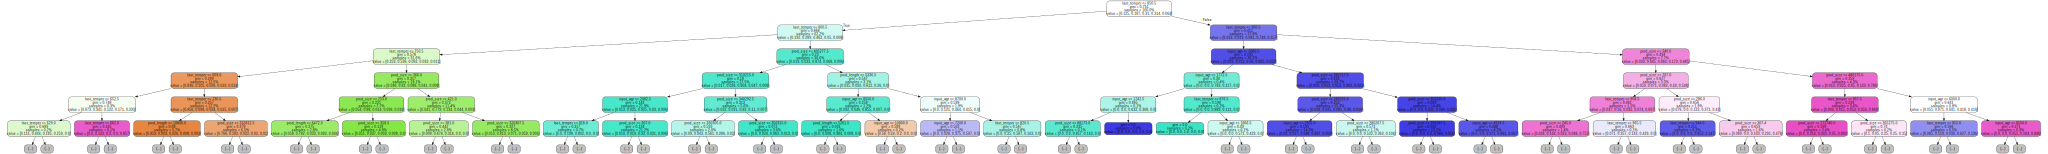

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

# 사이킷런 graphviz 모듈 처리(max_depth=5)
tree_image = export_graphviz(dt_model, max_depth=5, feature_names=X_train.columns, rounded = True, filled=True, proportion=True)

# 결정나무 이미지 시각화
display(graphviz.Source(tree_image))

### 5-3. 모델 성능 평가

* 분류모델 성능 평가
  * **정확도(Accuracy)** - 전체 표본 중 정확히 분류된 표본의 수를 의미한다.
  * **오차행렬(ConfusionMatrix)** - 타겟의 원래 클래스와 모형이 예측한 클래스가 일치하는지는 갯수로 센 결과를 표나 나타낸 것이다. 정답 클래스는 행(row)으로 예측한 클래스는 열(column)로 나타낸다.
  * **정밀도(Precision)** - 모델이 정답이라고 에측한 것 중에서 실제로 정답인 수를 의미한다.
  * **재현율(Recall)** - 실제 정답 중에서 모델이 정답이라고 맞춘 수를 의미한다.
  * **F1 Score** - Precision과 Recall의 조화평균을 의미한다.

* 분류모델 주요 성능평가 함수 정의

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

# 분류모델 주요 성능 평가 지표 함수 정의 - 오차행렬(혼동행렬)
def evaluate_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    return confusion

# 분류모델 주요 성능 평가 지표 함수 정의 - 정확도, 정밀도, 재현율, F1-스코어
def evaluate_classifier(y_test, pred):
    # confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='micro')

    print('오차행렬{0}\n'.format(evaluate_confusion_matrix(y_test, pred)))
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 스코어: {0:.4f}'.format(accuracy, precision, recall, f1))

* **랜덤포레스트(Random Forest) 모델 성능 평가 확인**

In [ ]:
# 랜덤포레스트 모델 성능 평가 확인 함수 처리
evaluate_classifier(y_test, rf_pred)

오차행렬[[ 581   35   10    6    3]
 [  36  960   31   16   10]
 [  15   45 1632   31   17]
 [   9   27   55 1573   14]
 [   7   10   14   24  328]]

정확도: 0.9244, 정밀도: 0.9247, 재현율: 0.9117, F1 스코어: 0.9244


* 랜덤포레스트 모델 오차행렬 성능 평가 확인

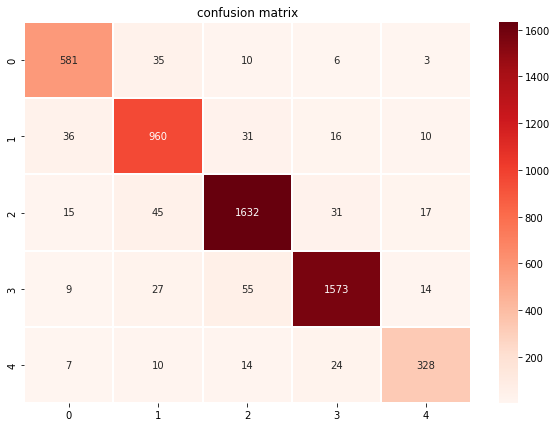

In [ ]:
# 오차행렬 평가 함수 처리
cf_matrix = evaluate_confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(10, 7))
plt.title('confusion matrix')
# sns.heatmap(cf_matrix, cmap=plt.cm.Greens, linewidths=1, annot=True, fmt='g')
sns.heatmap(cf_matrix, cmap=plt.cm.Reds, linewidths=1, annot=True, fmt='g')

* **의사결정나무(Decision Tree) 모델 성능 평가 확인**

In [ ]:
# 의사결정나무 모델 성능 평가 확인 함수 처리
evaluate_classifier(y_test, dt_pred)

오차행렬[[ 571   39   14    6    5]
 [  46  931   37   26   13]
 [  17   50 1626   31   16]
 [  14   24   67 1560   13]
 [   5   11   19   23  325]]

정확도: 0.9133, 정밀도: 0.9135, 재현율: 0.8992, F1 스코어: 0.9133


* 의사결정나무(Decision Tree) 모델 오차행렬 성능 평가 확인

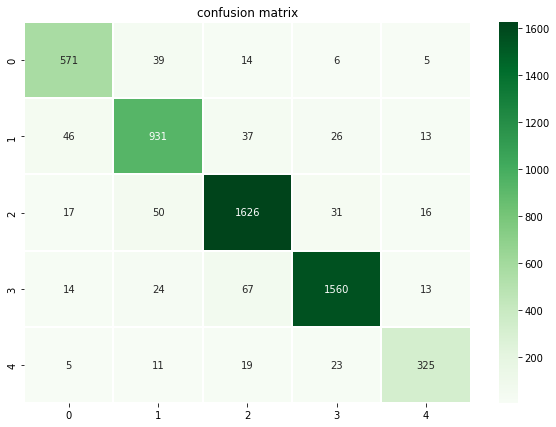

In [ ]:
# 오차행렬 평가 함수 처리
cf_matrix = evaluate_confusion_matrix(y_test, dt_pred)

plt.figure(figsize=(10, 7))
plt.title('confusion matrix')
# sns.heatmap(cf_matrix, cmap=plt.cm.Reds, linewidths=1, annot=True, fmt='g')
sns.heatmap(cf_matrix, cmap=plt.cm.Greens, linewidths=1, annot=True, fmt='g')

# **6. 모델튜닝(의사결정나무 모델)**

### 6-1. 하이퍼파라미터 튜닝

* max_depth - 트리의 최대 깊이
  * default = None
  * root node와 leaf node 사이의 가장 긴 경로 설정
  * 너무 큰 값을 설정할 경우 모델이 복잡해지고, 과적합이 발생할 수 있으므로 적절히 제어 필요
* min_samples_split - 노드를 분할하기 위한 최소한의 샘플 데이터수
  * Default = 2
  * 과적합을 제어하는데 사용하며, 작게 설정할 수록 분할 노드가 많아져 과적합 가능성 증가 함
* min_samples_leaf - 리프 노드가 가져야할 최소 샘플 수
  * default = 1
  * min_samples_split과 함께 과적합 제어 용도로 사용 함
  * 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요
* max_leaf_nodes - 말단 노드의 최대 갯수
  * Default = None
  * 과적합 방지하기 위해 사용 함

* 의사결정나무 모델의 하이퍼 파라미터 확인

In [ ]:
# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_model.get_params())

DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 11, 'splitter': 'best'}


* 의사결정나무(Decision Tree) 주요 파라미터 튜닝
  * Test할 주요 하이퍼파라미터를 리스트로 입력값을 설정하고 반복문을 사용해서 모델학습 및 예측하여 최적의 파리미터 값을 찾는다.
  * 정확도가 높은 하이퍼파리미터 값을 사용한다.


In [ ]:
# Test할 주요 파라미터 값들을 리스트 설정
max_depths = [6, 8 ,10, 12, 16, 20, 24]
min_samples_split = [2, 4, 6, 8, 10, 12]
min_samples_leaf = [1, 2, 3, 4, 5, 6]
max_leaf_nodes = [None, 2, 4, 6, 8, 10]

# max_depth 값을 변화 시키면서 학습과 테스트 셋에서의 예측 성능 측정
print('<max_depth>')
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))
print('\n')

# min_samples_split 값을 변화 시키면서 학습과 테스트 셋에서의 예측 성능 측정
print('<min_samples_split>')
for min_split in min_samples_split:
    dt_clf = DecisionTreeClassifier(min_samples_split=min_split, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('min_samples_split = {0} 정확도: {1:.4f}'.format(min_split , accuracy))
print('\n')

# min_samples_leaf 값을 변화 시키면서 학습과 테스트 셋에서의 예측 성능 측정
print('<min_samples_leaf>')
for min_leaf in min_samples_leaf:
    dt_clf = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('min_samples_leaf = {0} 정확도: {1:.4f}'.format(min_leaf , accuracy))
print('\n')

print('<max_leaf_nodes>')
for max_leaf_node in max_leaf_nodes:
    dt_clf = DecisionTreeClassifier(max_leaf_nodes=max_leaf_node, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('max_leaf_nodes = {0} 정확도: {1:.4f}'.format(max_leaf_node , accuracy))                

<max_depth>
max_depth = 6 정확도: 0.8685
max_depth = 8 정확도: 0.8818
max_depth = 10 정확도: 0.8974
max_depth = 12 정확도: 0.9071
max_depth = 16 정확도: 0.9146
max_depth = 20 정확도: 0.9138
max_depth = 24 정확도: 0.9129


<min_samples_split>
min_samples_split = 2 정확도: 0.9127
min_samples_split = 4 정확도: 0.9131
min_samples_split = 6 정확도: 0.9065
min_samples_split = 8 정확도: 0.9014
min_samples_split = 10 정확도: 0.9029
min_samples_split = 12 정확도: 0.9003


<min_samples_leaf>
min_samples_leaf = 1 정확도: 0.9127
min_samples_leaf = 2 정확도: 0.9064
min_samples_leaf = 3 정확도: 0.8993
min_samples_leaf = 4 정확도: 0.8976
min_samples_leaf = 5 정확도: 0.8994
min_samples_leaf = 6 정확도: 0.8962


<max_leaf_nodes>
max_leaf_nodes = None 정확도: 0.9127
max_leaf_nodes = 2 정확도: 0.5642
max_leaf_nodes = 4 정확도: 0.8076
max_leaf_nodes = 6 정확도: 0.8528
max_leaf_nodes = 8 정확도: 0.8537
max_leaf_nodes = 10 정확도: 0.8544


### 6-2. Grid Search 방법을 이용한 하이퍼파라미터 튜닝

* **Gird Search**
  * Grid search(격자 탐색)은 모델 하이퍼 파라미터에 넣을 수 있는 값들을 순차적으로 입력한 뒤에 가장 높은 성능을 보이는 하이퍼 파라미터들을 찾는 탐색 방법이다.

  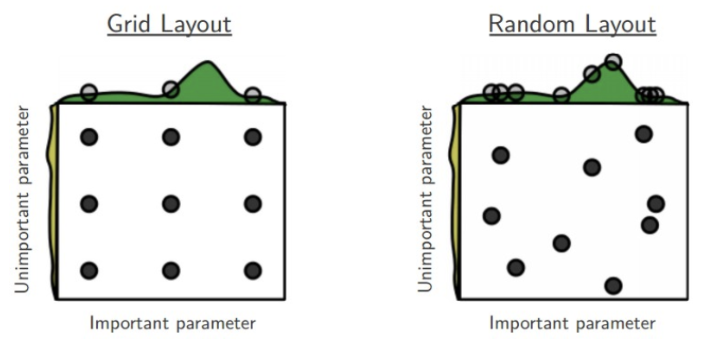

* 최적의 하이퍼파라미터 값으로 모델 성능 평가 확인

In [ ]:
from sklearn.model_selection import GridSearchCV

# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의
grid_parameters = {'max_depth': [6, 8 ,10, 12, 16, 20, 24],
                   'min_samples_split': [2, 4, 6, 8, 10, 12],
                   'min_samples_leaf':[1, 2, 3, 4, 5, 6],
                   'max_leaf_nodes':[None, 2, 4, 6, 8, 10],
                   'splitter': ['best', 'random']}

# 의사결정나무 모델객체 선언
dt_clf = DecisionTreeClassifier(random_state=33)
# GridSearchCV 방법을 통해 Best 하이퍼파라미터 검색
# refit=True는 최적의 파라미터를 찾으면 이것을 기준으로 다음 학습을 시킴
# grid_dt = GridSearchCV(dt_clf, param_grid = grid_parameters, cv = 5, refit = True)
grid_dt = GridSearchCV(dt_clf, param_grid = grid_parameters, refit = True)

# 모델 학습
grid_dt.fit(X_train, y_train)              

# 파라미터 튜닝한 결과를 DataFrame 형식으로 변환하여 평균 Score값을 테스트별로 출력
result = pd.DataFrame(grid_dt.cv_results_['params'])
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
display(result.sort_values(by='mean_test_score', ascending=False))

# GridSearchCV 객체의 fit( )을 수행하면 최고 성능일 때의 하이퍼파라미터값과 그때의 평가 결과 값이 각각 best_params_, best_score_ 속성에 기록된다.
# 최적의 파라미터와 최고의 정확도 출력
print('\n')
print('GridSearchCV 최적 파라미터:', grid_dt.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_dt.best_score_))

,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,splitter,mean_test_score
1730,16,NaN,1,4,best,0.903021
1728,16,NaN,1,2,best,0.902943
1296,12,NaN,1,2,best,0.902631
1298,12,NaN,1,4,best,0.902319
1312,12,NaN,2,6,best,0.901850
...,...,...,...,...,...,...
937,10,2.0,1,2,random,0.409853
1851,16,2.0,5,4,random,0.409853
143,6,2.0,6,12,random,0.409853
1853,16,2.0,5,6,random,0.409853




GridSearchCV 최적 파라미터: {'max_depth': 16, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
GridSearchCV 최고 정확도:0.9030


* Grid Search 방법을 이용한 최적의 하이퍼파라미터 값을 가지고 최종 성능 평가 확인

In [ ]:
# 최적의 하이퍼파라미터 값으로 모델 성능 평가 확인
best_hyper_parameters = grid_dt.best_estimator_
y_pred = best_hyper_parameters.predict(X_test)

print('최적 파라미터 조합:', grid_dt.best_params_)
# 의사결정나무 성능 평가 확인 함수 호출
evaluate_classifier(y_test, y_pred)

최적 파라미터 조합: {'max_depth': 16, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
오차행렬[[ 574   44    8    5    4]
 [  50  932   35   25   11]
 [  16   52 1622   36   14]
 [  15   22   68 1559   14]
 [   7   12   26   23  315]]

정확도: 0.9113, 정밀도: 0.9116, 재현율: 0.8945, F1 스코어: 0.9113


* Grid Search의 최적의 파라미터 값의 결과를 DataFrame으로 변환하여 표로 출력하여 확인
  * cv_results_에 저장된 결과를 rank_test_score 내림차순으로 정렬하여 출력
  * rank_test_score는 성능 순위를 나타낸다.

In [ ]:
# Grid Search의 결과를 데이터프레임으로 변환하여 출력
pd.DataFrame(grid_dt.cv_results_).sort_values(by='rank_test_score').T

,1730,1728,1296,1298,1312,1732,2162,2594,2160,1302,...,2289,2291,1373,2293,2295,1375,2297,2299,2281,539
mean_fit_time,0.026656,0.0273,0.025855,0.024933,0.02501,0.025767,0.027184,0.026442,0.02647,0.025328,...,0.004659,0.004748,0.00464,0.004983,0.004533,0.00479,0.004533,0.005107,0.004509,0.004507
std_fit_time,0.000539,0.001868,0.001846,0.00027,0.000567,0.000351,0.00193,0.000442,0.000284,0.000863,...,0.000323,0.000331,0.000062,0.001017,0.00011,0.00042,0.000073,0.000905,0.000069,0.000086
mean_score_time,0.002709,0.002988,0.002592,0.002631,0.002597,0.002632,0.002688,0.002686,0.00269,0.003028,...,0.001918,0.001926,0.001995,0.00191,0.00191,0.001936,0.001917,0.001977,0.001905,0.00199
std_score_time,0.000101,0.000691,0.000024,0.000064,0.000017,0.000028,0.000028,0.000075,0.000074,0.000797,...,0.000035,0.000055,0.000034,0.000057,0.000056,0.000059,0.000075,0.000096,0.000017,0.000183
param_max_depth,16,16,12,12,12,16,20,24,20,12,...,20,20,12,20,20,12,20,20,20,8
param_max_leaf_nodes,None,None,None,None,None,None,None,None,None,None,...,2,2,2,2,2,2,2,2,2,2
param_min_samples_leaf,1,1,1,1,2,1,1,1,1,1,...,5,5,1,6,6,1,6,6,5,3
param_min_samples_split,4,2,2,4,6,6,4,4,2,8,...,10,12,6,2,4,8,6,8,2,12
param_splitter,best,best,best,best,best,best,best,best,best,best,...,random,random,random,random,random,random,random,random,random,random
params,"{'max_depth': 16, 'max_leaf_nodes': None, 'min...","{'max_depth': 16, 'max_leaf_nodes': None, 'min...","{'max_depth': 12, 'max_leaf_nodes': None, 'min...","{'max_depth': 12, 'max_leaf_nodes': None, 'min...","{'max_depth': 12, 'max_leaf_nodes': None, 'min...","{'max_depth': 16, 'max_leaf_nodes': None, 'min...","{'max_depth': 20, 'max_leaf_nodes': None, 'min...","{'max_depth': 24, 'max_leaf_nodes': None, 'min...","{'max_depth': 20, 'max_leaf_nodes': None, 'min...","{'max_depth': 12, 'max_leaf_nodes': None, 'min...",...,"{'max_depth': 20, 'max_leaf_nodes': 2, 'min_sa...","{'max_depth': 20, 'max_leaf_nodes': 2, 'min_sa...","{'max_depth': 12, 'max_leaf_nodes': 2, 'min_sa...","{'max_depth': 20, 'max_leaf_nodes': 2, 'min_sa...","{'max_depth': 20, 'max_leaf_nodes': 2, 'min_sa...","{'max_depth': 12, 'max_leaf_nodes': 2, 'min_sa...","{'max_depth': 20, 'max_leaf_nodes': 2, 'min_sa...","{'max_depth': 20, 'max_leaf_nodes': 2, 'min_sa...","{'max_depth': 20, 'max_leaf_nodes': 2, 'min_sa...","{'max_depth': 8, 'max_leaf_nodes': 2, 'min_sam..."
